#### Imports

In [1]:
from cnn import *
import cv2
import pandas as pd
import seaborn as sn
from os import listdir
import matplotlib.pyplot as plt

#### Constants

In [2]:
CLASSES = 8
EPOCHS = 12
EX_PER_CLASS = 1200
LABELS = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immunoglobulin', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

#### Dataset

In [3]:
# Root Folder Name
FOLDER_NAME = 'Dataset'
# Class Folders
folders = listdir(FOLDER_NAME)
NR_CLASSES = len(folders)
# Walk over folders
data_X, data_Y = [], []
for i in range(NR_CLASSES):
    folder = folders[i]
    images = listdir(FOLDER_NAME + '/' + folder)
    print('Folder', i+1, '-', folder, ' | Size:', len(images))
    # Walk over images
    for image in images:
        path = FOLDER_NAME + '/' + folder + '/' + image
        # Process Image
        size = 50
        raw = cv2.imread(path)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(gray, (size, size))
        # Add to class data
        data_X.append(img / 255)
        data_Y.append(np.eye(NR_CLASSES)[i].reshape([-1, 1]))
# Convert to numpy
X = np.reshape(data_X, (len(data_X), 1, size, size))
Y = np.reshape(data_Y, (len(data_Y), -1, 1))

Folder 1 - basophil  | Size: 1218
Folder 2 - eosinophil  | Size: 3117
Folder 3 - erythroblast  | Size: 1551
Folder 4 - ig  | Size: 2895
Folder 5 - lymphocyte  | Size: 1214
Folder 6 - monocyte  | Size: 1420
Folder 7 - neutrophil  | Size: 3329
Folder 8 - platelet  | Size: 2348


#### Load Costs

In [4]:
train_cost_history = np.genfromtxt('Models/train_cost_e12.txt')
valid_cost_history = np.genfromtxt('Models/valid_cost_e12.txt')

#### Model

In [5]:
# Initalize Model
model = CNN()
# Conv 1
conv1 = Convolution(16, 3, X[0].shape)
model.add(conv1)
# Pool 1
pool1 = Pool(3, conv1.out_shape, 3)
model.add(pool1)
# Conv 2
conv2 = Convolution(32, 5, pool1.out_shape)
model.add(conv2)
# Pool 2
pool2 = Pool(2, conv2.out_shape, 2)
model.add(pool2)
# Flat
flat = Flat()
model.add(flat)
# Hidden
hidden1 = Dense(512, pool2.size) #1152
model.add(hidden1)
# Hidden
hidden2 = Dense(64, 512)
model.add(hidden2)
# Out
out = Dense(8, 64, 'softmax')
model.add(out)

In [6]:
# Load Model Data
model.load_weights('models/model_e12_a1e-3.txt')
model.cost_history = train_cost_history
model.valid_cost_history = valid_cost_history

Weights loaded from file models/model_e12_a1e-3.txt


#### Plot Costs

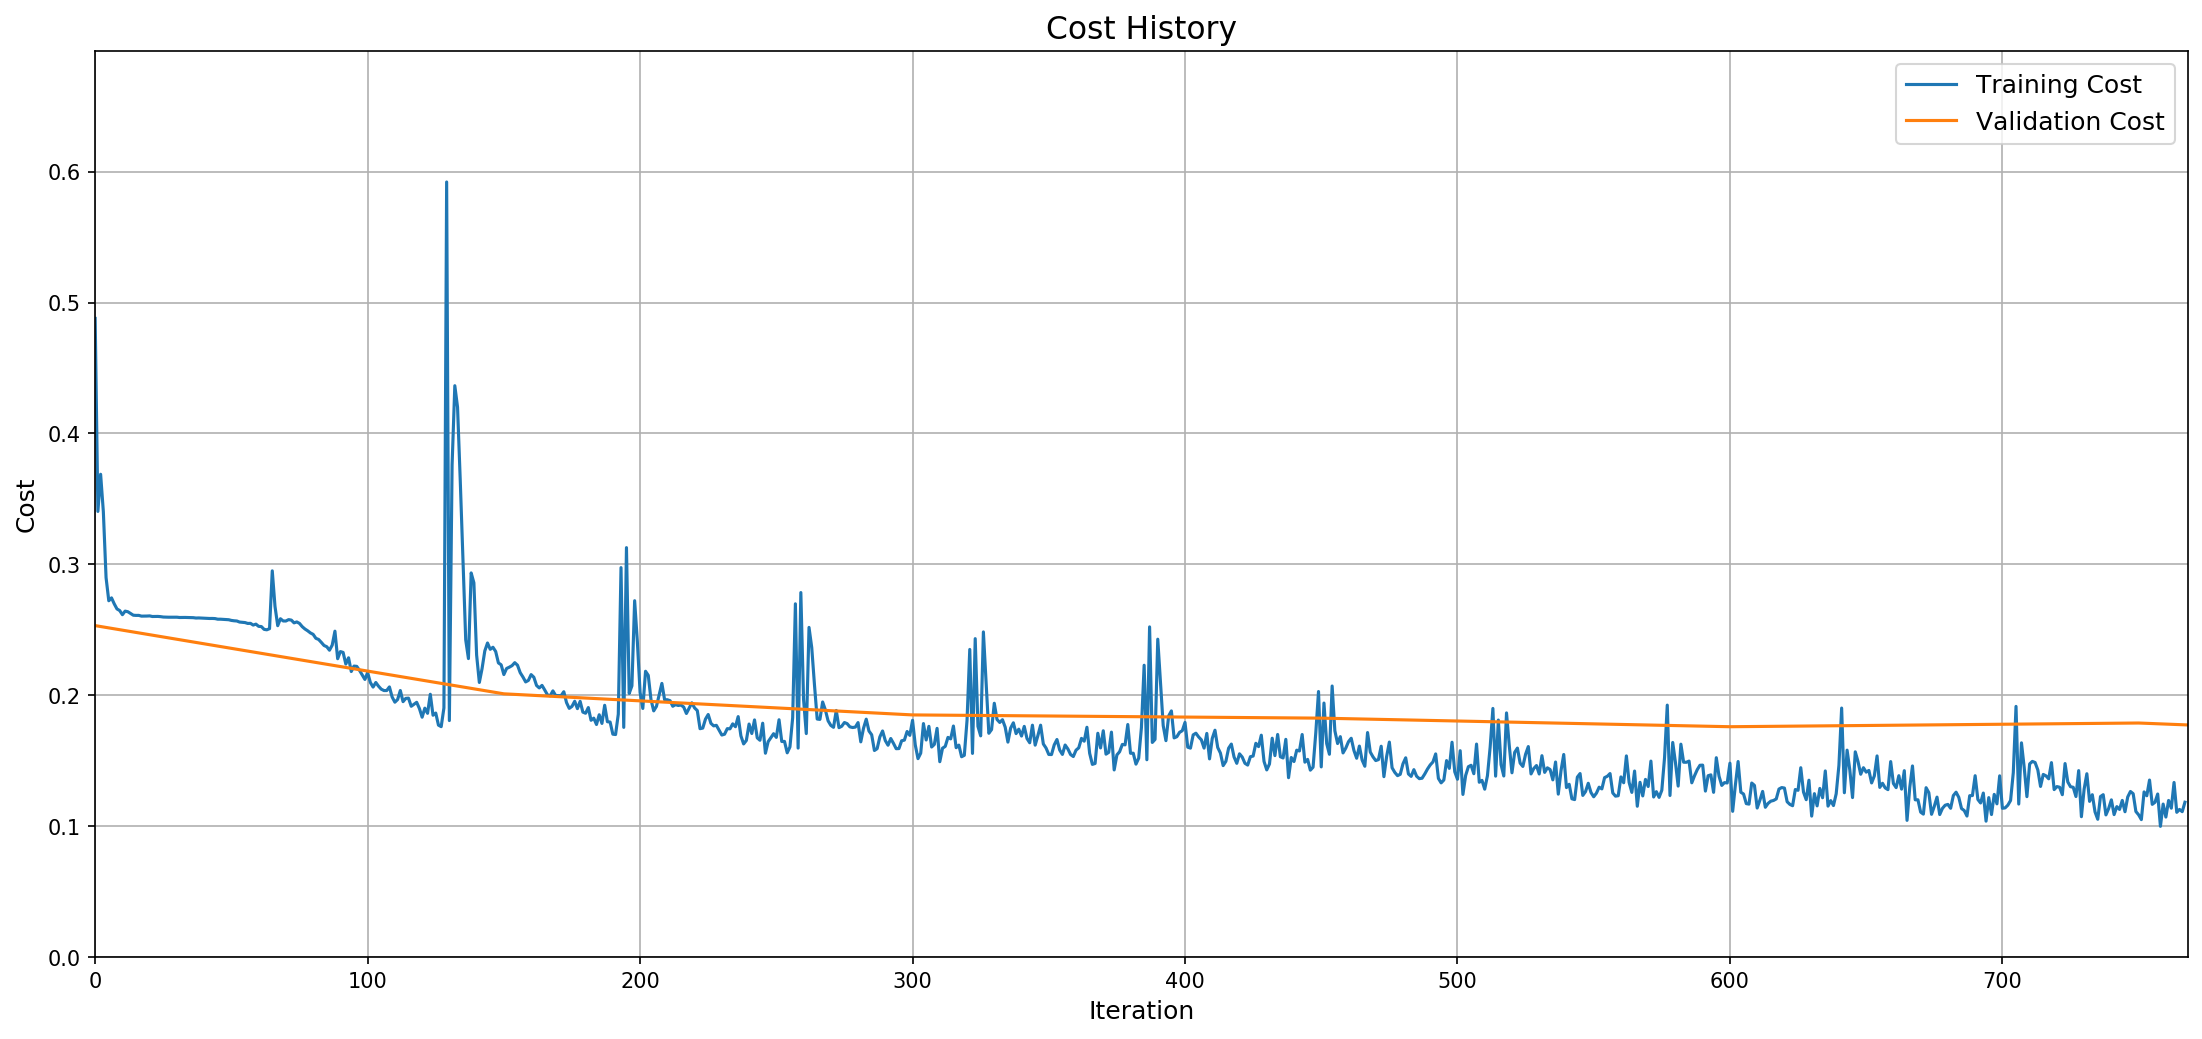

In [7]:
# COST HISTORY
plt.figure(figsize = [18, 8], dpi = 150)
plt.title('Cost History', fontsize = 15)

plt.xlim([0, len(model.cost_history)])
plt.ylim([0, max(model.cost_history)+0.1])
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Cost', fontsize = 12)

plt.plot(model.cost_history)
plt.plot(np.arange(EPOCHS) * (EX_PER_CLASS / CLASSES), model.valid_cost_history)
plt.legend(['Training Cost', 'Validation Cost'], fontsize = 12)

plt.grid()
plt.show()

#### Confusion Matrix

In [8]:
%%time
matrix = np.zeros((CLASSES, CLASSES))
correct = 0
for x, y in zip(X, Y):
    out = model.forward(x)
    pred = np.argmax(out)
    true = np.argmax(y)
    if pred == true: correct += 1
    matrix[true, pred] += 1
# Accuracy
acc = correct / len(X)
print(f'Dataset Accuracy: {acc:.2%}')

Dataset Accuracy: 63.36%
Wall time: 13min 32s


In [9]:
normalized = matrix / np.sum(matrix, 1)

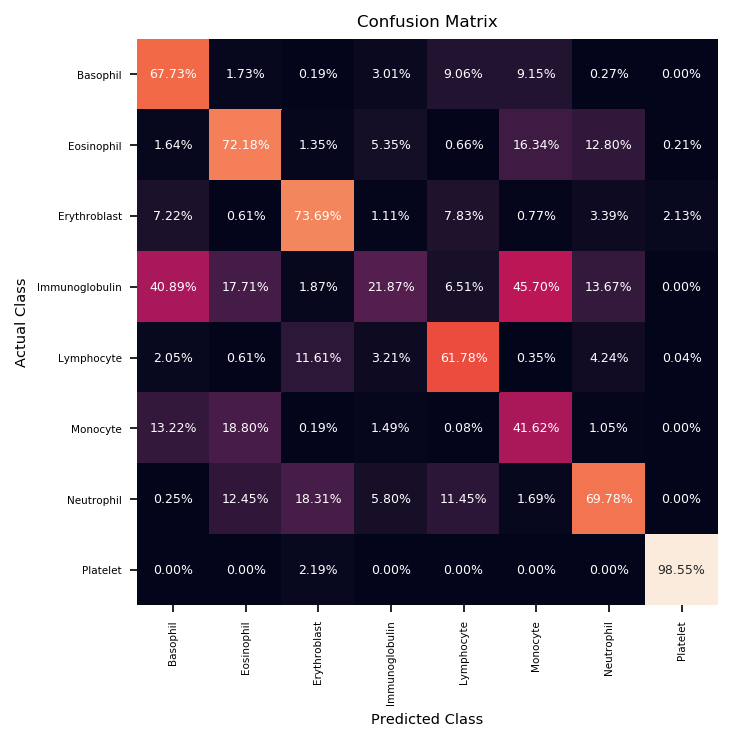

In [10]:
matrix_df = pd.DataFrame(normalized, index = LABELS, columns = LABELS)

plt.figure(figsize = [5, 5], dpi = 150)
sn.heatmap(matrix_df, annot = True, fmt = '.2%', annot_kws = {'fontsize':6}, cbar = False)

plt.title("Confusion Matrix", fontsize = 8)
plt.xlabel('Predicted Class', fontsize = 7)
plt.ylabel('Actual Class', fontsize = 7)

plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.show()

#### Progression

In [11]:
# Propagate Image
img = X[9]
out = model.forward(img)
print('Results:\n', out*100)

Results:
 [[78.78757067]
 [ 2.56212681]
 [ 1.94180202]
 [ 7.74566296]
 [ 0.68471321]
 [ 8.1536059 ]
 [ 0.12451842]
 [ 0.        ]]


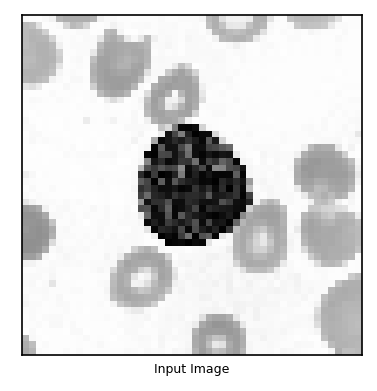

In [12]:
# Show Image
plt.figure(figsize = [3, 3], dpi = 150)

plt.xticks([])
plt.yticks([])
plt.xlabel("Input Image", fontsize = 6)

plt.imshow(img[0], 'gray')
plt.show()

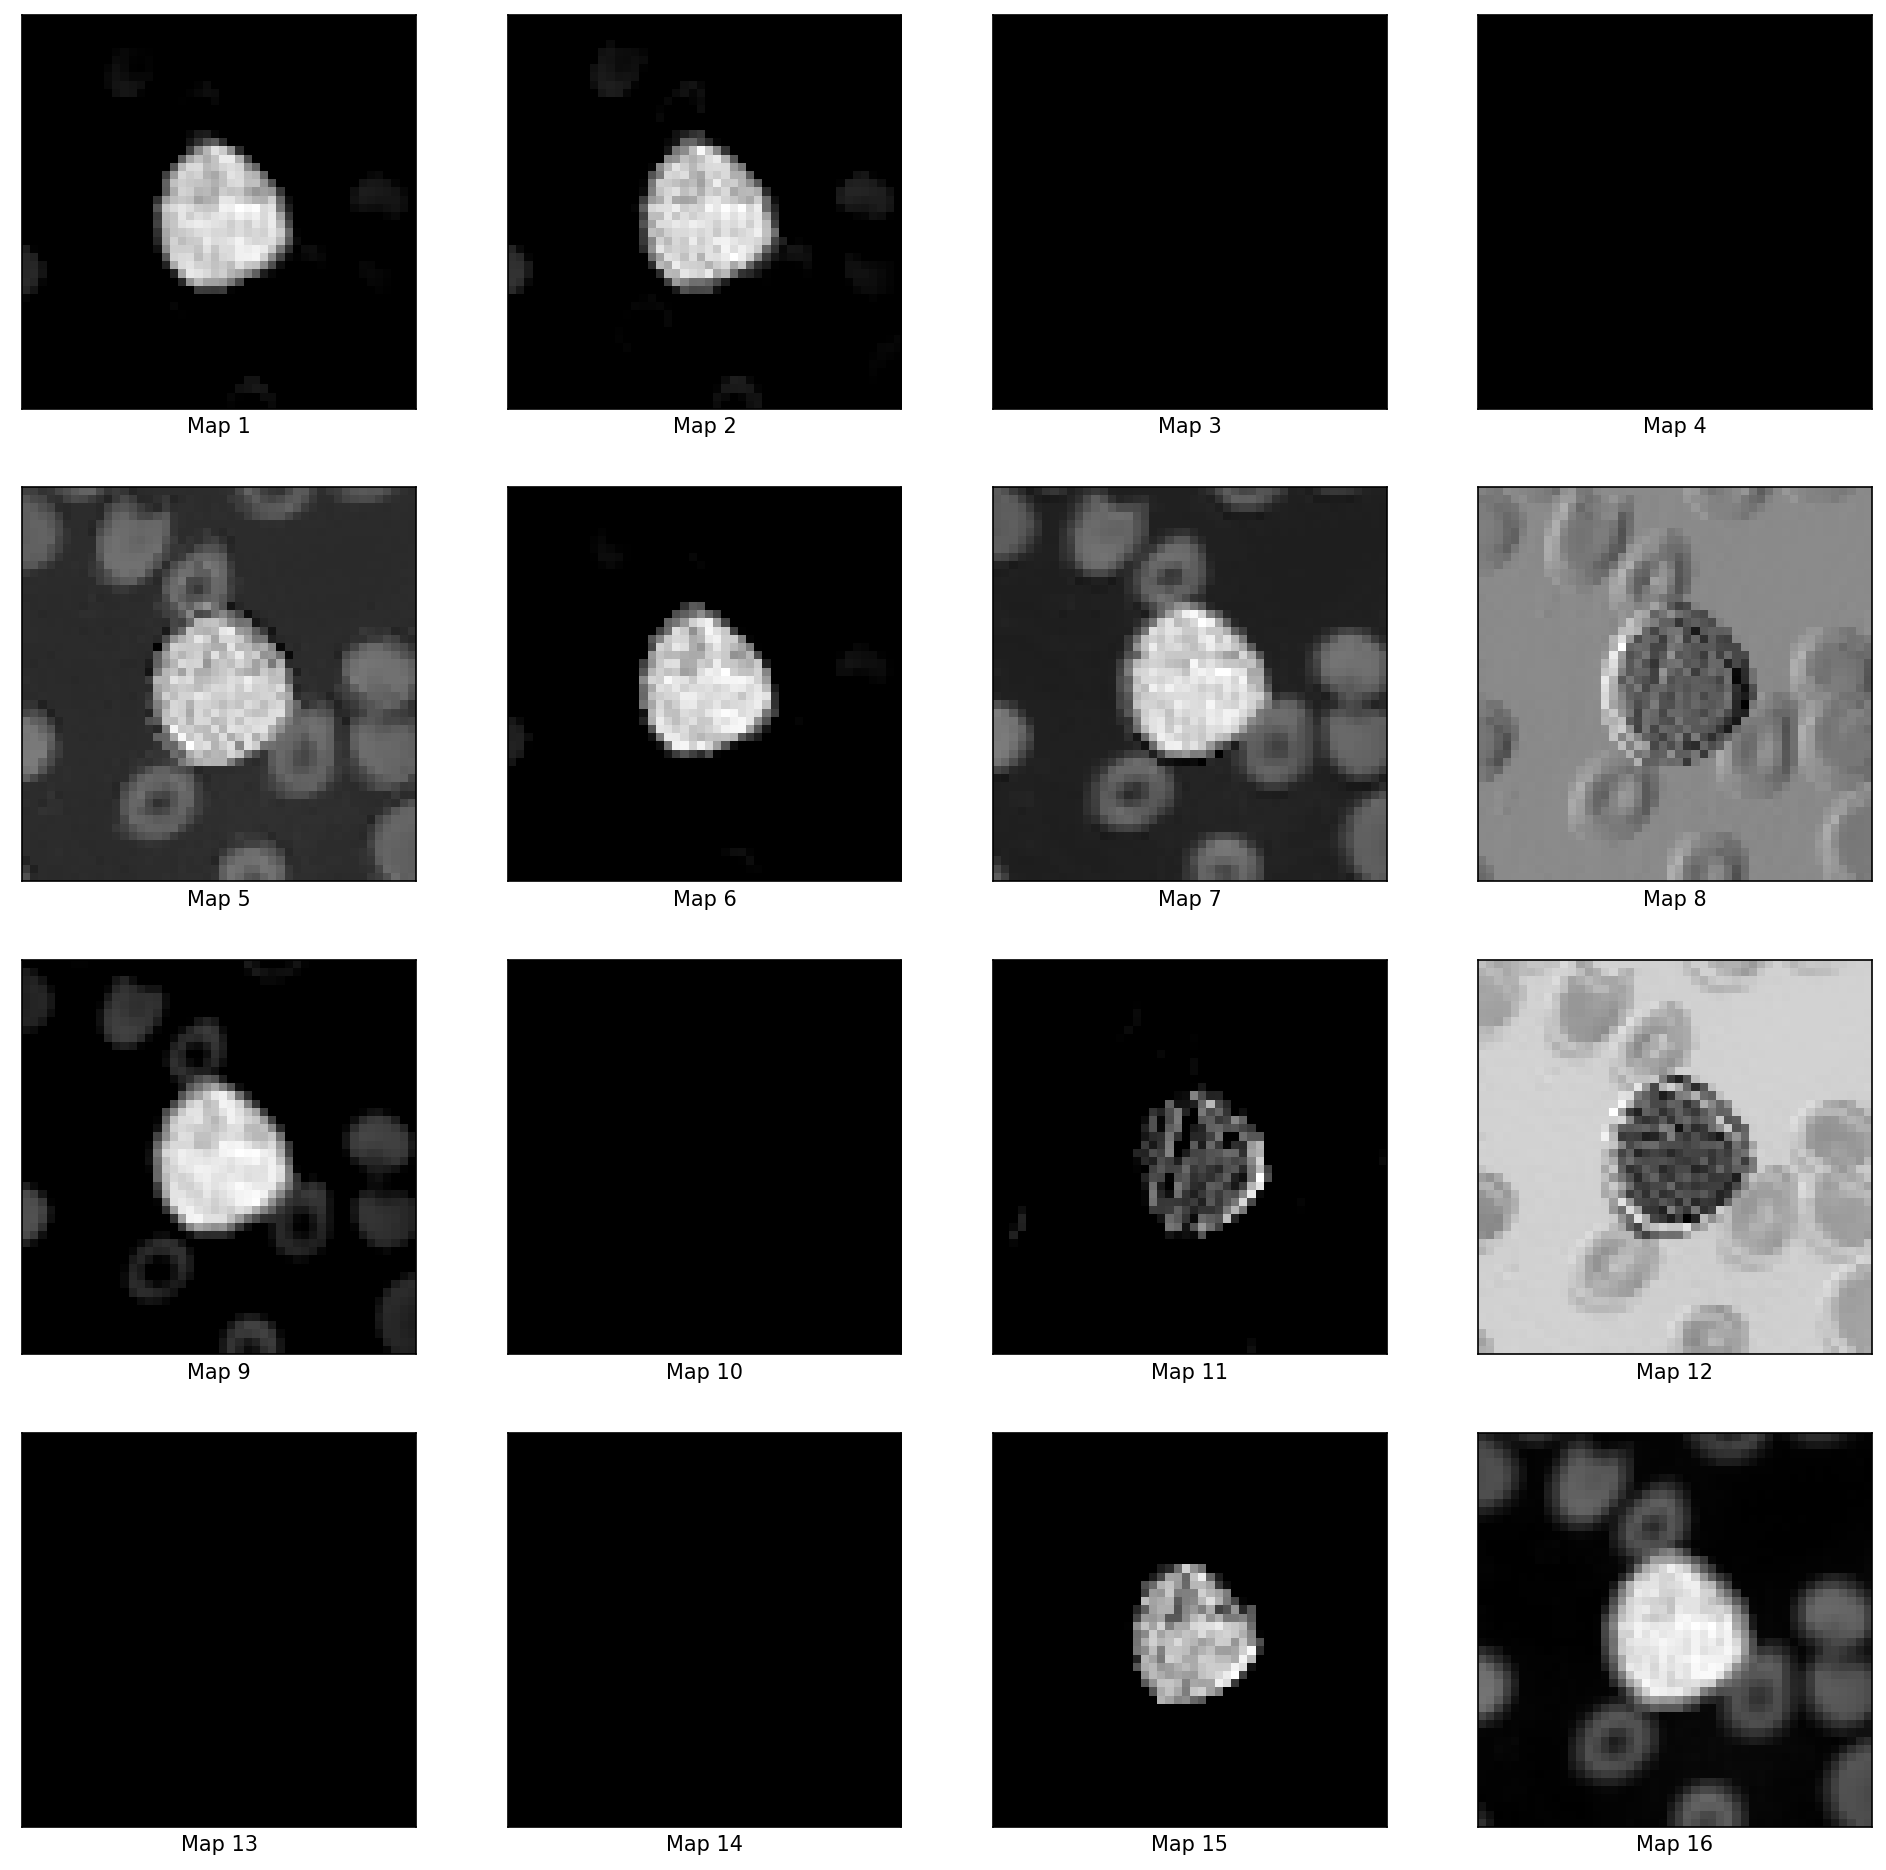

In [13]:
# Show Conv1 Results
out = model.layers[0].out

total = len(out)
im_per_row = 4
rows = int(total / im_per_row)

plt.figure(figsize = [16, 16], dpi = 150)
for i in range(rows):
    for j in range(im_per_row):
        index = i * im_per_row + j
        plt.subplot(rows, im_per_row, index+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Map " + str(index+1), fontsize = 10)
        plt.imshow(out[index], 'gray') 
plt.show()

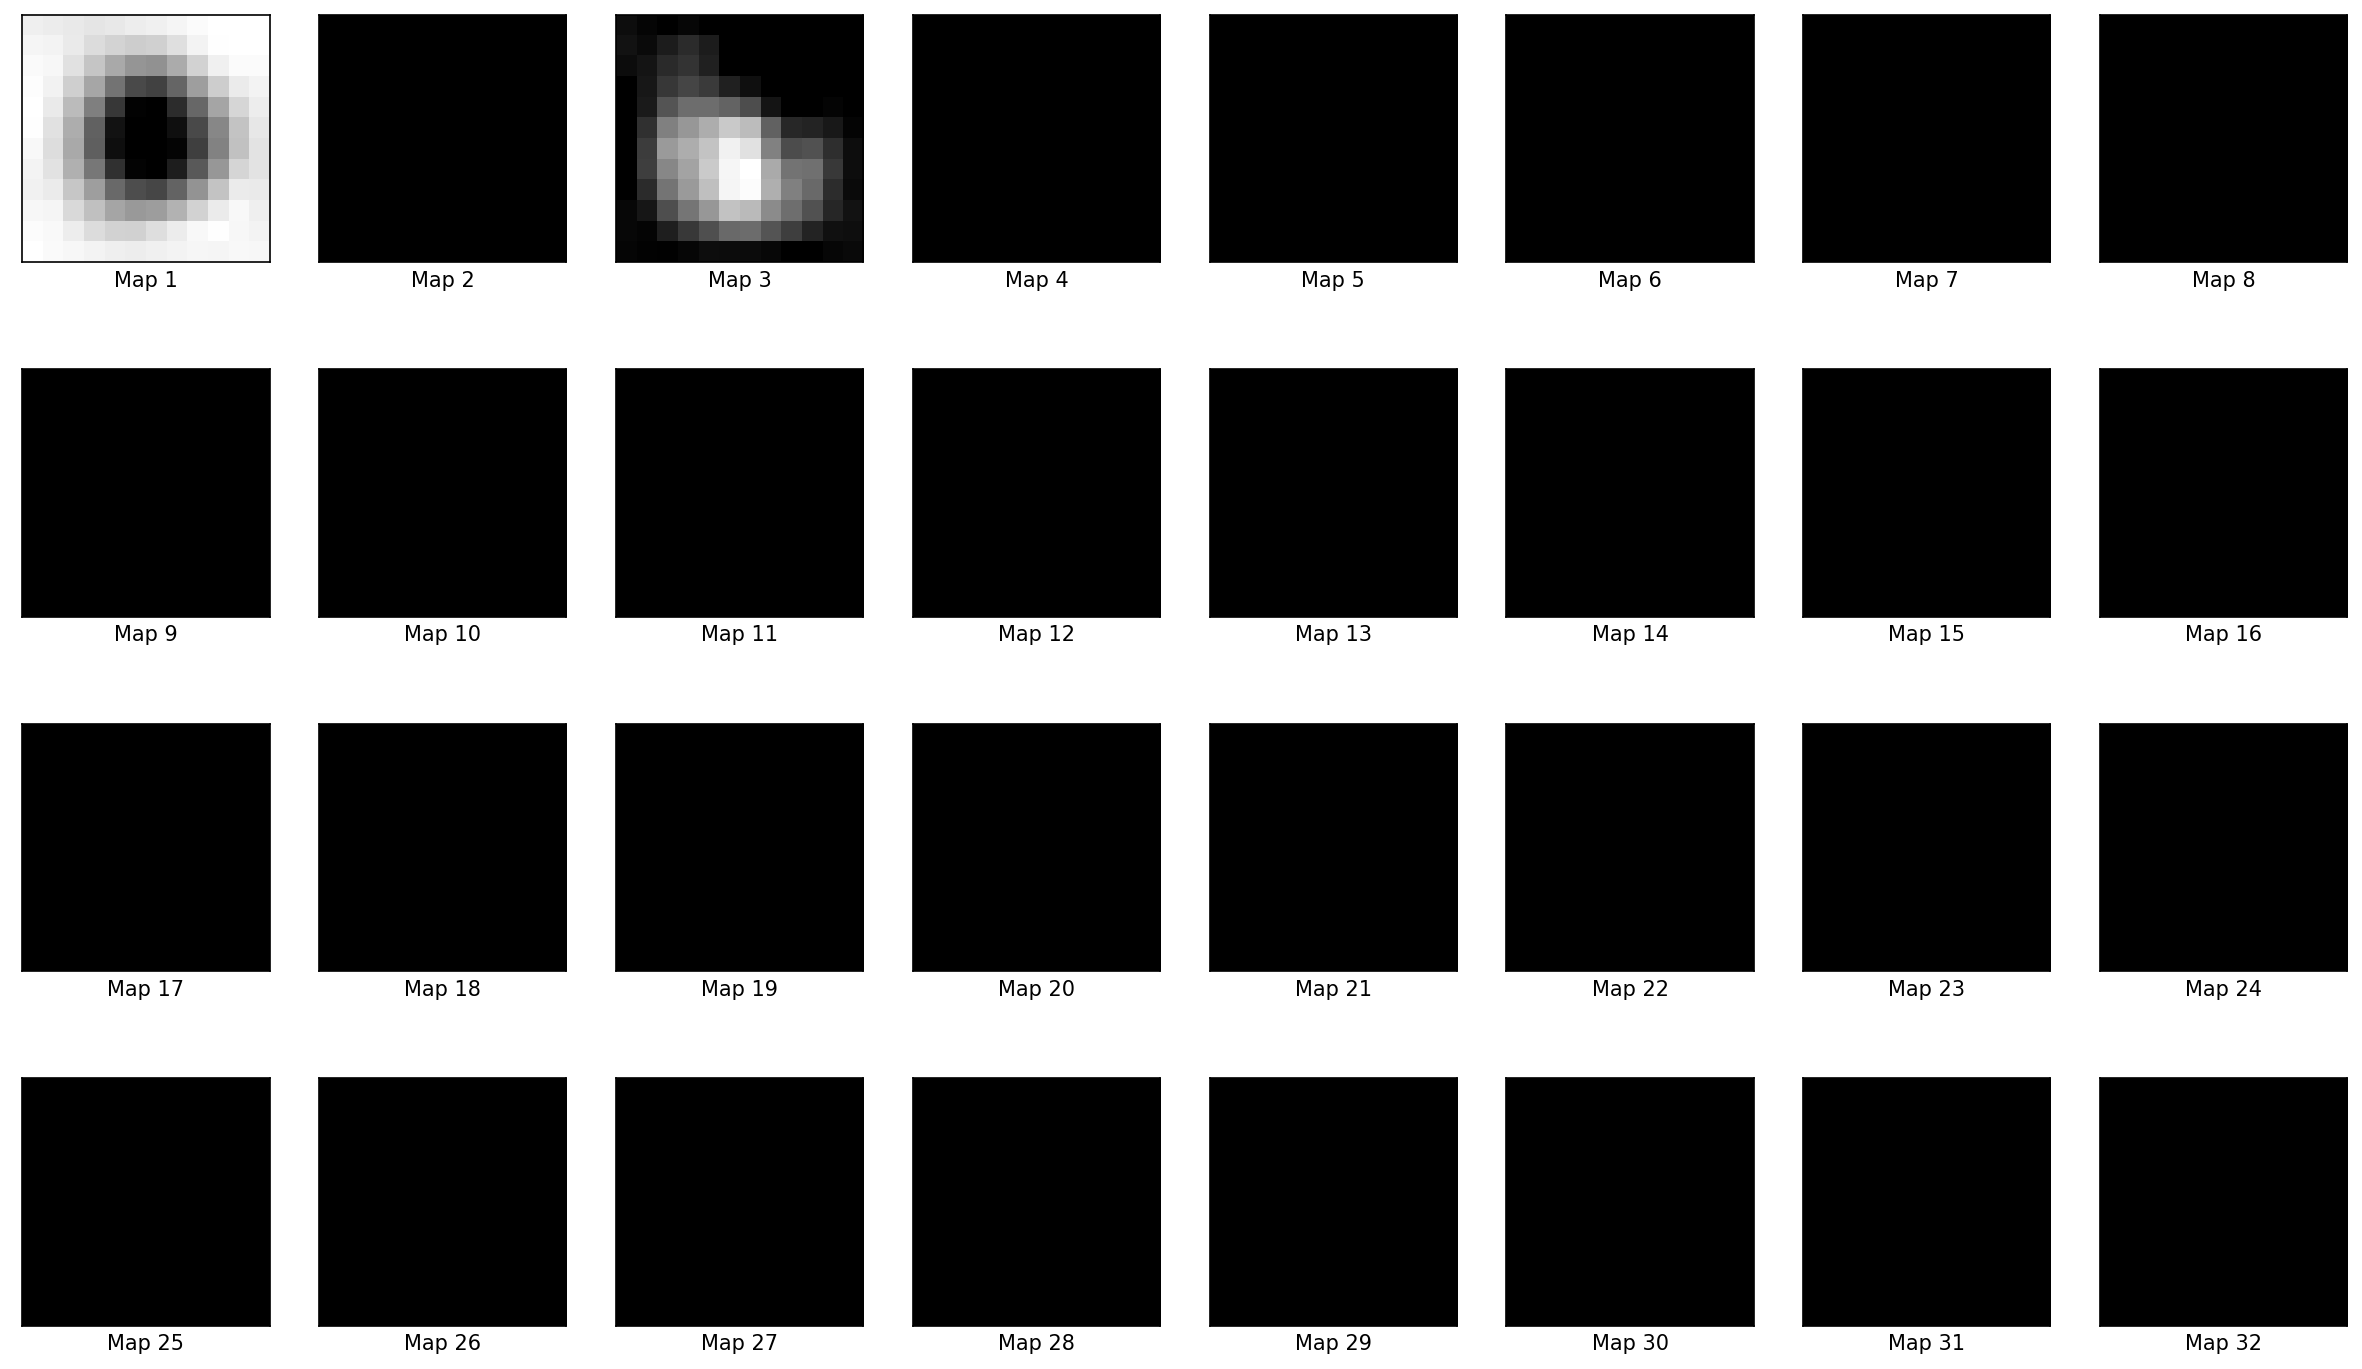

In [14]:
# Show Conv2 Results
out = model.layers[2].out

total = len(out)
im_per_row = 8
rows = int(total / im_per_row)

plt.figure(figsize = [20, 12], dpi = 150)
for i in range(rows):
    for j in range(im_per_row):
        index = i * im_per_row + j
        plt.subplot(rows, im_per_row, index+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Map " + str(index+1), fontsize = 10)
        plt.imshow(out[index], 'gray') 
plt.show()